# A Quantum distance-based classifier (part 1)

<center> Robert Wezeman, TNO </center>

<a name="contents"></a>

## Table of Contents

* [Introduction](#introduction)
* [Problem](#problem)
* [Amplitude Encoding](#amplitude)
* [Data preprocessing](#dataset)
* [Quantum algorithm](#algorithm)
* [Conclusion and further work](#conclusion)

In [1]:
# Import external python file
import nbimporter
import numpy as np
from data_plotter import get_bin, DataPlotter  # for easier plotting
DataPlotter = DataPlotter()

$$ \newcommand{\ket}[1]{\left|{#1}\right\rangle} $$


<a name="introduction"></a>

## Introduction

Consider the following scatter plot of the first two flowers in [the famous Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set)

<img src="images/plot.png">


Notice that just two features, the sepal width and the sepal length, divide the two different Iris species into different regions in the plot. This gives rise to the question: given only the sepal length and sepal width of a flower can we classify the flower by their correct species? This type of problem, also known as [statistical classification](https://en.wikipedia.org/wiki/Statistical_classification), is a common problem in machine learning. In general, a classifier is constructed by letting it learn a function which gives the desired output based on a sufficient amount of data. This is called supervised learning, as the desired output (the labels of the data points) are known. After learning, the classifier can classify an unlabeled data point based on the learned function. The quality of a classifier improves if it has a larger training dataset it can learn on. The true power of this quantum classifier becomes clear when using extremely large data sets.
In this notebook we will describe how to build a distance-based classifier on the Quantum Inspire using amplitude encoding. It turns out that, once the system is initialized in the desired state, regardless of the size of training data, the actual algorithm consists of only 3 actions, one Hadamard gate and two measurements. This has huge implications for the scalability of this problem for large data sets. Using only 4 qubits we show how to encode two data points, both of a different class, to predict the label for a third data point. In this notebook we will demonstrate how to use the Quantum Inspire SDK using QASM-code, we will also provide the code to obtain the same results for the ProjectQ framework.


[Back to Table of Contents](#contents)

<a name="problem"></a>

## Problem

We define the following binary classification problem: Given the data set
$$\mathcal{D} = \Big\{ ({\bf x}_1, y_1), \ldots ({\bf x}_M , y_M)  \Big\},$$
consisting of $M$ data points $x_i\in\mathbb{R}^n$ and corresponding labels $y_i\in \{-1, 1\}$, give a prediction for the label $\tilde{y}$ corresponding to an unlabeled data point $\bf\tilde{x}$. The classifier we shall implement with our quantum circuit is a distance-based classifier and is given by
\begin{equation}\newcommand{\sgn}{{\rm sgn}}\newcommand{\abs}[1]{\left\lvert#1\right\rvert}\label{eq:classifier} \tilde{y} = \sgn\left(\sum_{m=0}^{M-1} y_m \left[1-\frac{1}{4M}\abs{{\bf\tilde{x}}-{\bf x}_m}^2\right]\right). \hspace{3cm} (1)\end{equation}

This is a typical $M$-nearest-neighbor model, where each data point is given a weight related to the distance measure. To implement this classifier on a quantum computer, we need a way to encode the information of the training data set in a quantum state. We do this by first encoding the training data in the amplitudes of a quantum system, and then manipulate the amplitudes of then the amplitudes will be manipulated by quantum gates such that we obtain a result representing the above classifier. Encoding input features in the amplitude of a quantum system is known as amplitude encoding.


[Back to Contents](#contents)

<a name="amplitude"></a>

## Amplitude encoding

Suppose we want to encode a classical vector $\bf{x}\in\mathbb{R}^N$ by some amplitudes of a quantum system. We assume $N=2^n$ and that $\bf{x}$ is normalised to unit length, meaning ${\bf{x}^T{x}}=1$. We can encode $\bf{x}$ in the amplitudes of a $n$-qubit system in the following way
\begin{equation}
{\bf x} = \begin{pmatrix}x^1 \\ \vdots \\ x^N\end{pmatrix} \Longleftrightarrow{} \ket{\psi_{{\bf x}}} = \sum_{i=0}^{N-1}x^i\ket{i},
\end{equation}
where $\ket{i}$ is the $i^{th}$ entry of the computational basis $\left\{\ket{0\ldots0},\ldots,\ket{1\ldots1}\right\}$. By applying an efficient quantum algorithm (resources growing polynomially in the number of qubits $n$), one can manipulate the $2^n$ amplitudes super efficiently, that is $\mathcal{O}\left(\log N\right)$. This follows as manipulating all amplitudes requires an operation on each of the $n = \mathcal{O}\left(\log N\right)$ qubits. For algorithms to be truly super-efficient, the phase where the data is encoded must also be at most polynomial in the number of qubits. The idea of quantum memory, sometimes referred as quantum RAM (QRAM), is a particular interesting one. Suppose we first run some quantum algorithm, for example in quantum chemistry, with as output some resulting quantum states. If these states could be fed into a quantum classifier, the encoding phase is not needed anymore. Finding efficient data encoding systems is still a topic of active research. We will restrict ourselves here to the implementation of the algorithm, more details can be found in the references.

<a name="state"></a>
The algorithm requires the $n$-qubit quantum system to be in the following state
\begin{equation}\label{eq:prepstate}
\ket{\mathcal{D}} = \frac{1}{\sqrt{2M}} \sum_{m=0}^{M-1} \ket{m}\Big(\ket{0}\ket{\psi_{\bf\tilde{{x}}}} + \ket{1}\ket{\psi_{\bf{x}_m}}\Big)\ket{y_m}.\hspace{3cm} (2)
\end{equation}
Here $\ket{m}$ is the $m^{th}$ state of the computational basis used to keep track of the $m^{th}$ training input. The second register is a single ancillary qubit entangled with the third register. The excited state of the ancillary qubit is entangled with the $m^{th}$ training state $\ket{\psi_{{x}_m}}$, while the ground state is entangled with the new input state $\ket{\psi_{\tilde{x}}}$. The last register encodes the label of the $m^{th}$ training data point by
\begin{equation}
\begin{split}
y_m = -1 \Longleftrightarrow& \ket{y_m} = \ket{0},\\
y_m = 1 \Longleftrightarrow& \ket{y_m} = \ket{1}.
\end{split}
\end{equation}
Once in this state the algorithm only consists of the following three operations:

1. Apply a Hadamard gate on the second register to obtain

  $$\frac{1}{2\sqrt{M}} \sum_{m=0}^{M-1} \ket{m}\Big(\ket{0}\ket{\psi_{\bf\tilde{x}+x_m}} + \ket{1}\ket{\psi_{\bf\tilde{x}-x_m}}\Big)\ket{y_m},$$

  where $\ket{\psi_{\bf\tilde{{x}}\pm{x}_m}} = \ket{\psi_{\tilde{\bf{x}}}}\pm \ket{\psi_{\bf{x}_m}}$.

2. Measure the second qubit. We restart the algorithm if we measure a $\ket{1}$ and only continue if we are in the $\ket{0}$ branch. We continue the algorithm with a probability $p_{acc} = \frac{1}{4M}\sum_M\abs{{\bf\tilde{x}}+{\bf x}_m}^2$, for standardised random data this is usually around $0.5$. The resulting state is given by

\begin{equation}
\frac{1}{2\sqrt{Mp_{acc}}}\sum_{m=0}^{M-1}\sum_{i=0}^{N-1} \ket{m}\ket{0}\left({\tilde{x}}^i + x_m^i\right)\ket{i}\ket{y_m}.
\end{equation}

3. Measure the last qubit $\ket{y_m}$. The probability that we measure outcome zero is given by
\begin{equation}
p(q_4=0) = \frac{1}{4Mp_{acc}}\sum_{m|y_m=0}\abs{\bf{\tilde{{x}}+{x}_m}}^2.
\end{equation}

In the special case where the amount of training data for both labels is equal, this last measurement relates to the classifier as described in previous section by
\begin{equation}
\tilde{y} = \left\{
\begin{array}{lr}
-1 & : p(q_4 = 0 ) > p(q_4 = 1)\\
+1 & : p(q_4 = 0 ) < p(q_4 = 1)
\end{array}
\right.
\end{equation}
By setting $\tilde{y}$ to be the most likely outcome of many measurement shots, we obtain the desired distance-based classifier.


[Back to Table of Contents](#contents)

<a name="dataset"></a>

## Data preprocessing

In the previous section we saw that for amplitude encoding we need a data set which is normalised. Luckily, it is always possible to bring data to this desired form with some data transformations. Firstly, we standardise the data to have zero mean and unit variance, then we normalise the data to have unit length. Both these steps are common methods in machine learning. Effectively, we only have to consider the angle between different data features.

To illustrate this procedure we apply it to the first two features of the famous Iris data set:


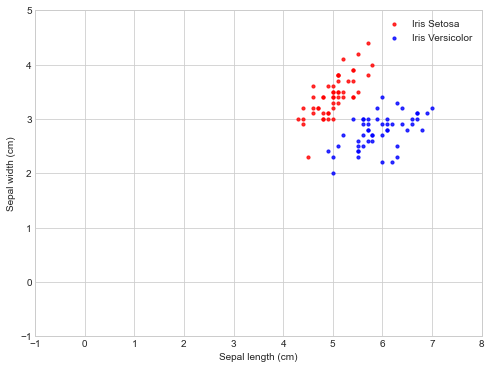

In [2]:
# Plot the data
from sklearn.datasets import load_iris

iris = load_iris()
features = iris.data.T
data = [el[0:101] for el in features][0:2]  # Select only the first two features of the dataset

half_len_data = len(data[0]) // 2
iris_setosa = [el[0:half_len_data] for el in data[0:2]]
iris_versicolor = [el[half_len_data:-1] for el in data[0:2]]

DataPlotter.plot_original_data(iris_setosa, iris_versicolor);  # Function to plot the data


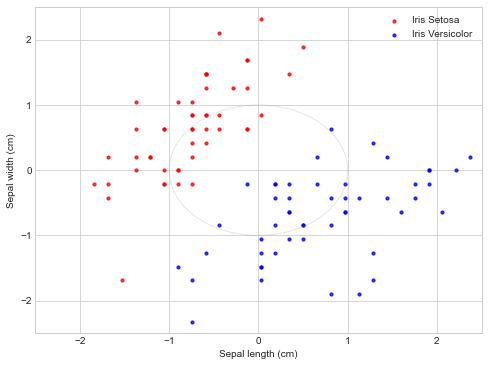

In [3]:
# Rescale the data
from sklearn import preprocessing  # Module contains method to rescale data to have zero mean and unit variance

# Rescale whole data-set to have zero mean and unit variance
features_scaled = [preprocessing.scale(el) for el in data[0:2]]
iris_setosa_scaled = [el[0:half_len_data] for el in features_scaled]
iris_versicolor_scaled = [el[half_len_data:-1] for el in features_scaled]

DataPlotter.plot_standardised_data(iris_setosa_scaled, iris_versicolor_scaled);  # Function to plot the data


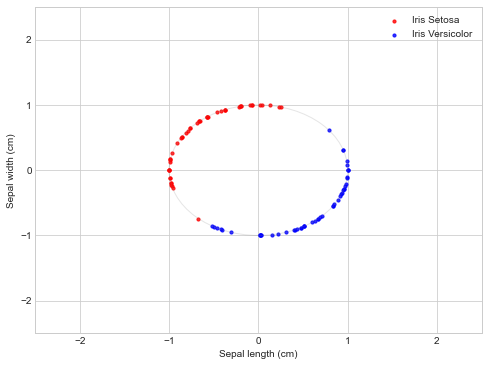

In [4]:
# Normalise the data
def normalise_data(arr1, arr2):
    """Normalise data to unit length
        input: two array same length
        output: normalised arrays
    """
    for idx in range(len(arr1)):
        norm = (arr1[idx]**2 + arr2[idx]**2)**(1 / 2)
        arr1[idx] = arr1[idx] / norm
        arr2[idx] = arr2[idx] / norm
    return [arr1, arr2]


iris_setosa_normalised = normalise_data(iris_setosa_scaled[0], iris_setosa_scaled[1])
iris_versicolor_normalised = normalise_data(iris_versicolor_scaled[0], iris_versicolor_scaled[1])
# Function to plot the data
DataPlotter.plot_normalised_data(iris_setosa_normalised, iris_versicolor_normalised);


[Table of Contents](#contents)

<a name="algorithm"></a>

## Quantum algorithm

Now we can start with our quantum algorithm on the Quantum Inspire. We describe how to build the algorithm for the simplest case with only two data points, each with two features, that is $M=N=2$. For this algorithm we need 4 qubits:
* One qubit for the index register $\ket{m}$
* One ancillary qubit
* One qubit to store the information of the two features of the data points
* One qubit to store the information of the classes of the data points

From the data set described in previous section we pick the following data set $\mathcal{D} = \big\{({\bf x}_1,y_1), ({\bf x}_2, y_2) \big\}$ where:
* ${\bf x}_1 = (0.9193, 0.3937)$, $y_1 = -1$,
* ${\bf x}_2 = (0.1411, 0.9899)$, $y_2 =  1$.

We are interested in the label $\tilde{y}$ for the data point ${\bf \tilde{x}} = (0.8670, 0.4984)$.


The amplitude encoding of these data points look like
\begin{equation}
\begin{split}
\ket{\psi_{\bf\tilde{x}}} & = 0.8670 \ket{0} + 0.4984\ket{1}, \\
\ket{\psi_{\bf x_1}} & = 0.9193 \ket{0} + 0.3937\ket{1},\\
\ket{\psi_{\bf x_2}} & = 0.1411 \ket{0} + 0.9899\ket{1}.
\end{split}
\end{equation}

Before we can run the actual algorithm we need to bring the system in the desired [initial state (equation 2)](#state) which can be obtain by applying the following combination of gates starting on $\ket{0000}$.

<img src="images/stateprep.png">

* **Part A:** In this part the index register is initialized and the ancilla qubit is brought in the desired state. For this we use the plain QASM language of the Quantum Inspire. Part A consists of two Hadamard gates:


In [5]:
def part_a():
    qasm_a = """version 1.0
qubits 4
prep_z q[0:3]
.part_a
H q[0:1] #execute Hadamard gate on qubit 0, 1
"""
    return qasm_a

 After this step the system is in the state
$$\ket{\mathcal{D}_A} = \frac{1}{2}\Big(\ket{0}+\ket{1}\Big)\Big(\ket{0}+\ket{1}\Big)\ket{0}\ket{0} $$


* **Part B:** In this part we encode the unlabeled data point $\tilde{x}$ by making use of a controlled rotation. We entangle the third qubit with the ancillary qubit. The angle $\theta$ of the rotation should be chosen such that $\tilde{x}=R_y(\theta)\ket{0}$. By the definition of $R_y$ we have
$$ R_y(\theta)\ket{0} = \cos\left(\frac{\theta}{2}\right)\ket{0} + \sin\left(\frac{\theta}{2}\right)\ket{1}.$$
Therefore, the angle needed to rotate to the state $\psi=a\ket{0} + b\ket{1}$ is given by $\theta = 2\cos^{-1}(a)\cdot sign(b)$.
Quantum Inspire does not directly support controlled-$R_y$ gates, however we can construct it from other gates as shown in the figure below. In these pictures $k$ stand for the angle used in the $R_y$ rotation. <img src="images/partb.png">

In [6]:
def part_b(angle):
    half_angle = angle / 2
    qasm_b = """.part_b # encode test value x^tilde
CNOT q[1], q[2]
Ry q[2], -{0}
CNOT q[1], q[2]
Ry q[2], {0}
X q[1]
""".format(half_angle)
    return qasm_b

After this step the system is in the state
$$\ket{\mathcal{D}_B} = \frac{1}{2} \Big(\ket{0}+\ket{1}\Big)\Big(\ket{0}\ket{\tilde{{x}}}+\ket{1}\ket{0}\Big)\ket{0}$$


* **Part C:** In this part we encode the first data point $x_1$. The rotation angle $\theta$ is such that $\ket{x_1}  = R_y(\theta)\ket{0}$. Now a double controlled-$R_y$ rotation is needed, and similar to Part B, we construct it from other gates as shown in the figure below. <img src="images/partc.png">


In [7]:
def part_c(angle):
    quarter_angle = angle / 4
    qasm_c = """.part_c # encode training x^0 value
toffoli q[0],q[1],q[2]
CNOT q[0],q[2]
Ry q[2], {0}
CNOT q[0],q[2]
Ry q[2], -{0}
toffoli q[0],q[1],q[2]
CNOT q[0],q[2]
Ry q[2], -{0}
CNOT q[0],q[2]
Ry q[2], {0}
X q[0]
""".format(quarter_angle)
    return qasm_c

After this step the system is in the state
$$\ket{\mathcal{D}_C} = \frac{1}{2}\Bigg(\ket{0}\Big(\ket{0}\ket{\tilde{{x}}} + \ket{1}\ket{{x_1}}\Big) + \ket{1}\Big(\ket{0}\ket{\tilde{{x}}} + \ket{1}\ket{0}\Big)\Bigg) \ket{0}$$

* **Part D:** This part is almost an exact copy of part C, however now with $\theta$ chosen such that $\ket{{x}_2}  = R_y(\theta)\ket{0}$.


In [8]:
def part_d(angle):
    quarter_angle = angle / 4
    qasm_d = """.part_d # encode training x^1 value
toffoli q[0],q[1],q[2]
CNOT q[0],q[2]
Ry q[2], {0}
CNOT q[0],q[2]
Ry q[2], -{0}
toffoli q[0],q[1],q[2]
CNOT q[0],q[2]
Ry q[2], -{0}
CNOT q[0],q[2]
Ry q[2], {0}
""".format(quarter_angle)
    return qasm_d

After this step the system is in the state
$$\ket{\mathcal{D}_D} = \frac{1}{2}\Bigg(\ket{0}\Big(\ket{0}\ket{\tilde{{x}}} + \ket{1}\ket{{x_1}}\Big) + \ket{1}\Big(\ket{0}\ket{\tilde{{x}}} + \ket{1}\ket{{x}_2}\Big)\Bigg) \ket{0}$$

* **Part E:** The last step is to label the last qubit with the correct class, this can be done using a simple CNOT gate between the first and last qubit to obtain the desired initial state
$$\ket{\mathcal{D}_E} = \frac{1}{2}\ket{0}\Big(\ket{0}\ket{\tilde{{x}}} + \ket{1}\ket{{x_1}}\Big)\ket{0} + \ket{1}\Big(\ket{0}\ket{\tilde{{x}}} + \ket{1}\ket{{x}_2}\Big)\ket{1}.
$$

In [9]:
def part_e():
    qasm_e = """.part_e # encode the labels
CNOT q[0], q[3]
"""
    return qasm_e

## The actual algorithm

Once the system is in this initial state, the algorithm itself only consists of one Hadamard gate and two measurements. If the first measurement gives the result $\ket{1}$, we have to abort the algorithm and start over again. However, these results can also easily be filtered out in a post-proecessing step.

In [10]:
def part_f():
    qasm_f = """
.part_f
H q[1]
"""
    return qasm_f

The circuit for the whole algorithm now looks like: <img src="images/full_circuit.png">

We can send our QASM code to the Quantum Inspire with the following data points

\begin{equation}
\begin{split}
\ket{\psi_{\tilde{x}}} & = 0.8670 \ket{0} + 0.4984\ket{1},\\
\ket{\psi_{x_1}} & = 0.9193 \ket{0} + 0.3937\ket{1},\\
\ket{\psi_{x_2}} & = 0.1411 \ket{0} + 0.9899\ket{1}.
\end{split}
\end{equation}


In [11]:
import os
from getpass import getpass
from coreapi.auth import BasicAuthentication
from quantuminspire.credentials import load_account, get_token_authentication, get_basic_authentication
from quantuminspire.api import QuantumInspireAPI
from math import acos
from math import pi

QI_EMAIL = os.getenv('QI_EMAIL')
QI_PASSWORD = os.getenv('QI_PASSWORD')
QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')

# input data points:
angle_x_tilde = 2 * acos(0.8670)
angle_x0 = 2 * acos(0.1411)
angle_x1 = 2 * acos(0.9193)


def get_authentication():
    """ Gets the authentication for connecting to the Quantum Inspire API."""
    token = load_account()
    if token is not None:
        return get_token_authentication(token)
    else:
        if QI_EMAIL is None or QI_PASSWORD is None:
            print('Enter email')
            email = input()
            print('Enter password')
            password = getpass()
        else:
            email, password = QI_EMAIL, QI_PASSWORD
        return get_basic_authentication(email, password)


authentication = get_authentication()
qi = QuantumInspireAPI(QI_URL, authentication)

# Build final QASM
final_qasm = part_a() + part_b(angle_x_tilde) + part_c(angle_x0) + part_d(angle_x1) + part_e() + part_f()

backend_type = qi.get_backend_type_by_name('QX single-node simulator')
result = qi.execute_qasm(final_qasm, backend_type=backend_type, number_of_shots=1, full_state_projection=True)

print(result['histogram'])


OrderedDict([('9', 0.3988584), ('4', 0.2768809), ('0', 0.1270332), ('13', 0.099428), ('2', 0.0658663), ('6', 0.0302195), ('15', 0.0013716), ('11', 0.0003419)])


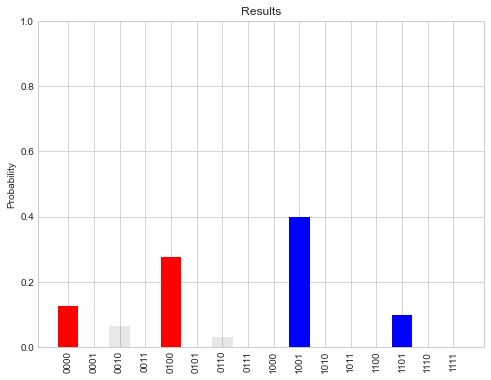

In [12]:
import matplotlib.pyplot as plt
from collections import OrderedDict


def bar_plot(result_data):
    res = [get_bin(el, 4) for el in range(16)]
    prob = [0] * 16

    for key, value in result_data['histogram'].items():
        prob[int(key)] = value

    # Set color=light grey when 2nd qubit = 1
    # Set color=blue when 2nd qubit = 0, and last qubit = 1
    # Set color=red when 2nd qubit = 0, and last qubit = 0
    color_list = [
        'red', 'red', (0.1, 0.1, 0.1, 0.1), (0.1, 0.1, 0.1, 0.1),
        'red', 'red', (0.1, 0.1, 0.1, 0.1), (0.1, 0.1, 0.1, 0.1),
        'blue', 'blue', (0.1, 0.1, 0.1, 0.1), (0.1, 0.1, 0.1, 0.1),
        'blue', 'blue', (0.1, 0.1, 0.1, 0.1), (0.1, 0.1, 0.1, 0.1)
                 ]
    plt.bar(res, prob, color=color_list)
    plt.ylabel('Probability')
    plt.title('Results')
    plt.ylim(0, 1)
    plt.xticks(rotation='vertical')
    plt.show()
    return prob


prob = bar_plot(result)

We only consider the events where the second qubit equals 0, that is, we only consider the events in the set $$\{0000, 0001, 0100, 0101, 1000, 1001, 1100, 1101\}$$

The label $\tilde{y}$ is now given by

\begin{equation}
\tilde{y} = \left\{
\begin{array}{lr}
-1 & : \#\{0000, 0001, 0100, 0101\} > \#\{1000, 1001, 1100, 1101\}\\
+1 & : \#\{1000, 1001, 1100, 1101\} > \#\{0000, 0001, 0100, 0101\}
\end{array}
\right.
\end{equation}

In [13]:
def summarize_results(prob, display=1):
    sum_label0 = prob[0] + prob[1] + prob[4] + prob[5]
    sum_label1 = prob[8] + prob[9] + prob[12] + prob[13]

    def y_tilde():
        if sum_label0 > sum_label1:
            return 0, ">"
        elif sum_label0 < sum_label1:
            return 1, "<"
        else:
            return "undefined", "="
    y_tilde_res, sign = y_tilde()
    if display:
        print("The sum of the events with label 0 is: {}".format(sum_label0))
        print("The sum of the events with label 1 is: {}".format(sum_label1))
        print("The label for y_tilde is: {} because sum_label0 {} sum_label1".format(y_tilde_res, sign))
    return y_tilde_res


summarize_results(prob);

The sum of the events with label 0 is: 0.4039141
The sum of the events with label 1 is: 0.4982864
The label for y_tilde is: 1 because sum_label0 < sum_label1


The following code will randomly pick two training data points and a random test point for the algorithm. We can compare the prediction for the label by the Quantum Inspire with the true label.

Data point [-0.9618124721790273, -0.27370927708221326] from label 0
Data point [0.9290645305669943, -0.3699176909020849] from label 1
Test point [-0.9804333429271337, -0.19685136544287737] from label 0 


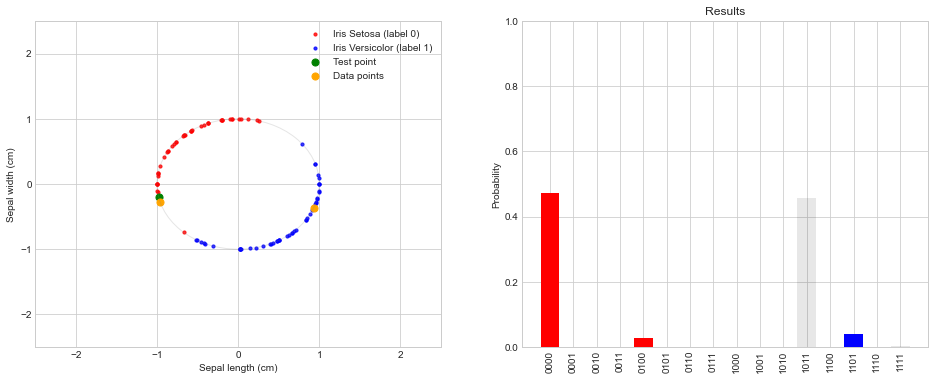

The sum of the events with label 0 is: 0.4992182
The sum of the events with label 1 is: 0.0404832
The label for y_tilde is: 0 because sum_label0 > sum_label1


In [14]:
from random import sample, randint
from numpy import sign


def grab_random_data():
    one_random_index = sample(range(50), 1)
    two_random_index = sample(range(50), 2)
    random_label = sample([1,0], 1) # random label

    # iris_setosa_normalised  # Label 0
    # iris_versicolor_normalised  # Label 1
    if random_label[0]:
        # Test data has label = 1, iris_versicolor
        data_label0 = [iris_setosa_normalised[0][one_random_index[0]],
                       iris_setosa_normalised[1][one_random_index[0]]]
        data_label1 = [iris_versicolor_normalised[0][two_random_index[0]],
                       iris_versicolor_normalised[1][two_random_index[0]]]
        test_data = [iris_versicolor_normalised[0][two_random_index[1]],
                     iris_versicolor_normalised[1][two_random_index[1]]]
    else:
        # Test data has label = 0, iris_setosa
        data_label0 = [iris_setosa_normalised[0][two_random_index[0]],
                       iris_setosa_normalised[1][two_random_index[0]]]
        data_label1 = [iris_versicolor_normalised[0][one_random_index[0]],
                       iris_versicolor_normalised[1][one_random_index[0]]]
        test_data = [iris_setosa_normalised[0][two_random_index[1]],
                     iris_setosa_normalised[1][two_random_index[1]]]
    return data_label0, data_label1, test_data, random_label


data_label0, data_label1, test_data, random_label = grab_random_data()

print("Data point {} from label 0".format(data_label0))
print("Data point {} from label 1".format(data_label1))
print("Test point {} from label {} ".format(test_data, random_label[0]))


def run_random_data(data_label0, data_label1, test_data):
    angle_x_tilde = 2 * acos(test_data[0]) * sign(test_data[1]) % (4 * pi)
    angle_x0 = 2 * acos(data_label0[0]) * sign(data_label0[1]) % (4 * pi)
    angle_x1 = 2 * acos(data_label1[0])* sign(data_label1[1]) % (4 * pi)

    # Build final QASM
    final_qasm = part_a() + part_b(angle_x_tilde) + part_c(angle_x0) + part_d(angle_x1) + part_e() + part_f()
    result_random_data = qi.execute_qasm(final_qasm, backend_type=backend_type, number_of_shots=1, full_state_projection=True)
    return result_random_data


result_random_data = run_random_data(data_label0, data_label1, test_data);

# Plot data points:
plt.rcParams['figure.figsize'] = [16, 6]  # Plot size
plt.subplot(1, 2, 1)
DataPlotter.plot_normalised_data(iris_setosa_normalised, iris_versicolor_normalised);
plt.scatter(test_data[0], test_data[1], s=50, c='green');  # Scatter plot data class ?
plt.scatter(data_label0[0], data_label0[1], s=50, c='orange');  # Scatter plot data class 0
plt.scatter(data_label1[0], data_label1[1], s=50, c='orange');  # Scatter plot data class 1
plt.legend(["Iris Setosa (label 0)", "Iris Versicolor (label 1)", "Test point", "Data points"])
plt.subplot(1, 2, 2)
prob_random_points = bar_plot(result_random_data);
summarize_results(prob_random_points);


To get a better idea how well this quantum classifier works we can compare the predicted label to the true label of the test datapoint. Errors in the prediction can have two causes. The quantum classifier does not give the right classifier prediction or the quantum classifier gives the right classifier prediction which for the selected data gives the wrong label. in general, the first type of errors can be reduced by increasing the number of times we run the algorithm. In our case, as we work with the simulator and our gates are deterministic ([no conditional gates](https://www.quantum-inspire.com/kbase/optimization-of-simulations/)), we do not have to deal with this first error if we use the true probability distribution. This can be done by using only a single shot without measurements.

In [ ]:
quantum_score = 0
error_prediction = 0
classifier_is_quantum_prediction = 0
classifier_score = 0
no_label = 0


def true_classifier(data_label0, data_label1, test_data):
    if np.linalg.norm(np.array(data_label1) - np.array(test_data)) < np.linalg.norm(np.array(data_label0) -
                                                                                    np.array(test_data)):
        return 1
    else:
        return 0


for idx in range(100):
    data_label0, data_label1, test_data, random_label = grab_random_data()
    result_random_data = run_random_data(data_label0, data_label1, test_data)
    classifier = true_classifier(data_label0, data_label1, test_data)

    sum_label0 = 0
    sum_label1 = 0
    for key, value in result_random_data['histogram'].items():
        if int(key) in [0, 1, 4, 5]:
            sum_label0 += value
        if int(key) in [8, 9, 12, 13]:
            sum_label1 += value
    if sum_label0 > sum_label1:
        quantum_prediction = 0
    elif sum_label1 > sum_label0:
        quantum_prediction = 1
    else:
        no_label += 1
        continue


    if quantum_prediction == classifier:
        classifier_is_quantum_prediction += 1

    if random_label[0] == classifier:
        classifier_score += 1

    if quantum_prediction == random_label[0]:
        quantum_score += 1
    else:
        error_prediction += 1

print("In this sample of 100 data points:")
print("the classifier predicted the true label correct", classifier_score, "% of the times")
print("the quantum classifier predicted the true label correct", quantum_score, "% of the times")
print("the quantum classifier predicted the classifier label correct",
      classifier_is_quantum_prediction, "% of the times")
print("Could not assign a label ", no_label, "times")

<a name="conclusion"></a>

## Conclusion and further work

How well the quantum classifier performs, hugely depends on the chosen data points. In case the test data point is significantly closer to one of the two training data points the classifier will result in a one-sided prediction. The other case, where the test data point has a similar distance to both training points, the classifier struggles to give an one-sided prediction. Repeating the algorithm on the same data points, might sometimes give different measurement outcomes. This type of error can be improved by running the algorithm using more shots. In the examples above we only used the true probability distribution (as if we had used an infinite number of shots). By running the algorithm instead with 512 or 1024 shots this erroneous behavior can be observed. In case of an infinite number of shots, we see that the quantum classifier gives the same prediction as classically expected.

The results of this toy example already shows the potential of a quantum computer in machine learning. Because the actual algorithm consists of only three operations, independent of the size of the data set, it can become extremely useful for tasks such as pattern recognition on large data sets. The next step is to extend this toy model to contain more data features and a larger training data set to improve the prediction. As not all data sets are best classified by a distance-based classifier, implementations of other types of classifiers might also be interesting. For more information on this particular classifier see the reference [ref](https://arxiv.org/abs/1703.10793).

[Back to Table of Contents](#contents)

### References

* Book: [Schuld and Petruccione, Supervised learning with Quantum computers, 2018](https://www.springer.com/us/book/9783319964232)
* Article: [Schuld, Fingerhuth and Petruccione, Implementing a distance-based classifier with a quantum interference circuit, 2017](https://arxiv.org/abs/1703.10793)

## The same algorithm for the projectQ framework

In [ ]:
from math import acos
import os
from getpass import getpass

from quantuminspire.credentials import load_account, get_token_authentication, get_basic_authentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.projectq.backend_qx import QIBackend

from projectq import MainEngine
from projectq.backends import ResourceCounter
from projectq.meta import Compute, Control, Loop, Uncompute
from projectq.ops import CNOT, CZ, All, H, Measure, Toffoli, X, Z, Ry, C
from projectq.setups import restrictedgateset

QI_EMAIL = os.getenv('QI_EMAIL')
QI_PASSWORD = os.getenv('QI_PASSWORD')
QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')


def get_authentication():
    """ Gets the authentication for connecting to the Quantum Inspire API."""
    token = load_account()
    if token is not None:
        return get_token_authentication(token)
    else:
        if QI_EMAIL is None or QI_PASSWORD is None:
            print('Enter email:')
            email = input()
            print('Enter password')
            password = getpass()
        else:
            email, password = QI_EMAIL, QI_PASSWORD
        return get_basic_authentication(email, password)


# Remote Quantum Inspire backend #
authentication = get_authentication()
qi_api = QuantumInspireAPI(QI_URL, authentication)

compiler_engines = restrictedgateset.get_engine_list(one_qubit_gates="any",
                                                     two_qubit_gates=(CNOT, CZ, Toffoli))
compiler_engines.extend([ResourceCounter()])

qi_backend = QIBackend(quantum_inspire_api=qi_api)
qi_engine = MainEngine(backend=qi_backend, engine_list=compiler_engines)

# angles data points:
angle_x_tilde = 2 * acos(0.8670)
angle_x0 = 2 * acos(0.1411)
angle_x1 = 2 * acos(0.9193)

qubits = qi_engine.allocate_qureg(4)

# part_a
for qubit in qubits[0:2]:
    H | qubit

# part_b
C(Ry(angle_x_tilde), 1) | (qubits[1], qubits[2]) # Alternatively build own CRy gate as done above
X | qubits[1]

# part_c
C(Ry(angle_x0), 2) | (qubits[0], qubits[1], qubits[2]) # Alternatively build own CCRy gate as done above
X | qubits[0]

# part_d
C(Ry(angle_x1), 2) | (qubits[0], qubits[1], qubits[2]) # Alternatively build own CCRy gate as done above

# part_e
CNOT | (qubits[0], qubits[3])

# part_f
H | qubits[1]

qi_engine.flush()

# Results:
temp_results = qi_backend.get_probabilities(qubits)

res = [get_bin(el, 4) for el in range(16)]
prob = [0] * 16
for key, value in temp_results.items():
    prob[int(key[::-1], 2)] = value  # Reverse as projectQ has a different qubit ordering

color_list = [
    'red', 'red', (0.1, 0.1, 0.1, 0.1), (0.1, 0.1, 0.1, 0.1),
    'red', 'red', (0.1, 0.1, 0.1, 0.1), (0.1, 0.1, 0.1, 0.1),
    'blue', 'blue', (0.1, 0.1, 0.1, 0.1), (0.1, 0.1, 0.1, 0.1),
    'blue', 'blue', (0.1, 0.1, 0.1, 0.1), (0.1, 0.1, 0.1, 0.1)
             ]
plt.bar(res, prob, color=color_list)
plt.ylabel('Probability')
plt.title('Results')
plt.ylim(0, 1)
plt.xticks(rotation='vertical')
plt.show()
print("Results:")
print(temp_results)